<a href="https://colab.research.google.com/github/gnsandeep/Fine-Tuning-BERT/blob/master/TSC_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.5.1

     |████████████████████████████████| 1.3MB 13.3MB/s 
     |████████████████████████████████| 1.1MB 53.1MB/s 
     |████████████████████████████████| 890kB 53.0MB/s 
     |████████████████████████████████| 2.9MB 50.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9b4a0a492d7f94951bdcb94498450aaa6227dd97bbbad56f6820aea5fa693acc
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [3]:
twitterdata = pd.read_csv("dataPandas.csv")
twitterdata.tail()

,Tweets,Labels
4995,@USER You don't . I have purchased a lot on Am...,NOT_SARCASM
4996,@USER #Emotions you say 🤔 never knew that I th...,NOT_SARCASM
4997,"@USER @USER @USER You are so right ... "" Yes !...",NOT_SARCASM
4998,@USER @USER @USER Another lazy delusional vote...,NOT_SARCASM
4999,@USER @USER I hope you know no news outlet fro...,NOT_SARCASM


In [4]:
twitterdata_t = pd.read_csv("dftestdata.csv")
twitterdata_t.tail()

,ID,Tweets
1795,twitter_1796,@USER @USER @USER is definitely the best out t...
1796,twitter_1797,@USER @USER Ye let her out run wild and infect...
1797,twitter_1798,"@USER @USER @USER Thanks for that , I would ha..."
1798,twitter_1799,@USER @USER @USER Yes also #found this on #new...
1799,twitter_1800,@USER @USER @USER you still need to send the l...


In [5]:
twitterdata.shape,twitterdata_t.shape

((5000, 2), (1800, 2))

In [6]:
#remove URL
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'http(\S)+', r'')
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'http ...', r'')
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'http', r'')
twitterdata[twitterdata['Tweets'].str.contains(r'http')]
# remove RT, @
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'(RT|rt)[ ]*@[ ]*[\S]+',r'')
twitterdata[twitterdata['Tweets'].str.contains(r'RT[ ]?@')]
#twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'@[\S]+',r'')​
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'@[\S]+',r'')

#remove non-ascii words and characters
twitterdata['Tweets'] = [''.join([i if ord(i) < 128 else '' for i in text]) for text in twitterdata['Tweets']]
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'_[\S]?',r'')
#remove &, < and >
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'&amp;?',r'and')
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'&lt;',r'<')
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'&gt;',r'>')
# remove extra space
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'[ ]{2, }',r' ')
# insert space between punctuation marks
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'([\w\d]+)([^\w\d ]+)', r'\1 \2')
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'([^\w\d ]+)([\w\d]+)', r'\1 \2')
# lower case and strip white spaces at both ends
twitterdata['Tweets'] = twitterdata['Tweets'].str.lower()
twitterdata['Tweets'] = twitterdata['Tweets'].str.strip()

In [7]:
#remove URL
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.replace(r'http(\S)+', r'')
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.replace(r'http ...', r'')
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.replace(r'http', r'')
twitterdata_t[twitterdata_t['Tweets'].str.contains(r'http')]
# remove RT, @
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.replace(r'(RT|rt)[ ]*@[ ]*[\S]+',r'')
twitterdata_t[twitterdata_t['Tweets'].str.contains(r'RT[ ]?@')]
#twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'@[\S]+',r'')​
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.replace(r'@[\S]+',r'')

#remove non-ascii words and characters
twitterdata_t['Tweets'] = [''.join([i if ord(i) < 128 else '' for i in text]) for text in twitterdata_t['Tweets']]
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.replace(r'_[\S]?',r'')
#remove &, < and >
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.replace(r'&amp;?',r'and')
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.replace(r'&lt;',r'<')
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.replace(r'&gt;',r'>')
# remove extra space
twitterdata['Tweets'] = twitterdata['Tweets'].str.replace(r'[ ]{2, }',r' ')
# insert space between punctuation marks
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.replace(r'([\w\d]+)([^\w\d ]+)', r'\1 \2')
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.replace(r'([^\w\d ]+)([\w\d]+)', r'\1 \2')
# lower case and strip white spaces at both ends
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.lower()
twitterdata_t['Tweets'] = twitterdata_t['Tweets'].str.strip()

In [8]:
twitterdata.loc[twitterdata['Labels'] == 'SARCASM', 'Labels'] = 1
twitterdata.loc[twitterdata['Labels'] == 'NOT_SARCASM', 'Labels'] = 0

In [9]:
twitterdata.head()

,Tweets,Labels
0,i don ' t get this .. obviously you do care or...,1
1,trying to protest about . talking about him an...,1
2,he makes an insane about of money from the mov...,1
3,meanwhile trump won ' t even release his sat s...,1
4,pretty sure the anti - lincoln crowd claimed t...,1


In [10]:
twitterdata_t.head()

,ID,Tweets
0,twitter_1,"my 3 year old , that just finished reading nie..."
1,twitter_2,how many verifiable lies has he told now ? 15 ...
2,twitter_3,maybe docs just a scrub of a coach ... i mean ...
3,twitter_4,is just a cover up for the real hate inside ....
4,twitter_5,the irony being that he even has to ask why . ...


In [11]:
twitterdata['Labels'].value_counts(normalize = True)

1    0.5
0    0.5
Name: Labels, dtype: float64

In [12]:
train_text, temp_text, train_labels, temp_labels = train_test_split(twitterdata['Tweets'], twitterdata['Labels'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=twitterdata['Labels'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [13]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


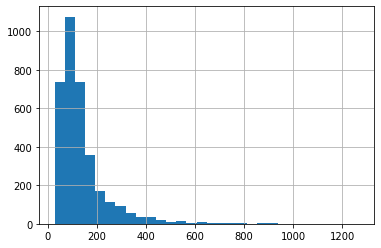

In [14]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [15]:
max_seq_len = 250

In [16]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    #pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    #pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    #pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

tokens_score = tokenizer.batch_encode_plus(
    twitterdata_t['Tweets'].tolist(),
    max_length = max_seq_len,
    #pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

In [62]:
len(twitterdata_t['Tweets'].tolist())

1800

In [17]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# score
score_seq = torch.tensor(tokens_score['input_ids'])
score_mask = torch.tensor(tokens_score['attention_mask'])


In [64]:
len(score_seq),len(score_mask)

(1800, 1800)

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)


# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)



In [70]:
score_data = TensorDataset(score_seq, score_mask)

score_sampler = SequentialSampler(score_data)

score_dataloader = DataLoader(score_data, sampler = score_sampler, batch_size=batch_size)

In [19]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [20]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 

      self.bert_drop = nn.Dropout(0.3)

      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)

      #_, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
      #  bo = self.bert_drop(o2)
      #  output = self.out(bo

      x = self.bert_drop(cls_hs)
      
      x = self.fc1(x)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [21]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [22]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [23]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1. 1.]


In [80]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 20

In [25]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [26]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.585
Validation Loss: 0.562

 Epoch 2 / 20
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.603
Validation Loss: 0.553

 Epoch 3 / 20
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.590
Validation Loss: 0.551

 Epoch 4 / 20
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.596
Validation Loss: 0.580

 Epoch 5 / 20
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.579
Validation Loss: 0.547

 Epoch 6 / 20
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.597
Validation Loss: 0.544

 Epoch 7 / 20
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.584
Validation Loss: 0.546

 Epoch 8 / 20
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.586
Validat

In [28]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [39]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
  #preds_score = model(score_seq.to(device), score_mask.to(device))
  #preds_score = preds_score.detach().cpu().numpy()

In [42]:
type(preds),preds.shape,type(test_y)

(numpy.ndarray, (750, 2), torch.Tensor)

In [46]:
preds1 = np.argmax(preds, axis = 1)
preds1.shape,preds1[:5]

((750,), array([0, 1, 1, 1, 0]))

In [30]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.72      0.64      0.68       375
           1       0.68      0.75      0.71       375

    accuracy                           0.70       750
   macro avg       0.70      0.70      0.70       750
weighted avg       0.70      0.70      0.70       750



In [31]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,241,134
1,92,283


In [71]:
# empty list to save the model predictions
score_total_preds = []

  # iterate over batches
for step,batch in enumerate(score_dataloader):
    
    # Progress update every 50 batches.
    if step % 10 == 0 and not step == 0:
      
        # Calculate elapsed time in minutes.
        #elapsed = format_time(time.time() - t0)
            
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(score_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask = batch

    # deactivate autograd
    with torch.no_grad():
      
        # model predictions
        preds = model(sent_id, mask)
        #print('Length of Preds :', len(preds))

        # compute the validation loss between actual and predicted values
        #loss = cross_entropy(preds,labels)

        #total_loss = total_loss + loss.item()

        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis = 1)


        score_total_preds.extend(preds.tolist())

  Batch    10  of     57.
  Batch    20  of     57.
  Batch    30  of     57.
  Batch    40  of     57.
  Batch    50  of     57.


In [72]:
len(score_total_preds)

1800

In [73]:
twitterdata_t['Predict'] = score_total_preds

In [74]:
twitterdata_t['PLabel'] = np.where(twitterdata_t['Predict'] == 1, "SARCASM", "NOT_SARCASM")

In [79]:
twitterdata_t.head()

,ID,Tweets,Predict,PLabel
0,twitter_1,"my 3 year old , that just finished reading nie...",0,NOT_SARCASM
1,twitter_2,how many verifiable lies has he told now ? 15 ...,1,SARCASM
2,twitter_3,maybe docs just a scrub of a coach ... i mean ...,1,SARCASM
3,twitter_4,is just a cover up for the real hate inside ....,1,SARCASM
4,twitter_5,the irony being that he even has to ask why . ...,1,SARCASM


In [78]:
twitterdata_t.to_csv('answer_BERT.txt', columns = ["ID" , "PLabel"] , header = False , index = False)

